# Designing models for CRC cell lines

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
import src.color_pal as pal
import src.common_data_processing as dphelp
import src.pymc3_analysis as pmanal
import theano
from src import crc_models, pymc3_sampling_api

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic() + gg.theme(strip_background=gg.element_blank()))
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 914
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data

In [2]:
data = dphelp.read_achilles_data(
    Path("..", "modeling_data", "depmap_CRC_data_subsample.csv")
)
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


## Model Experimentation

In [3]:
total_size = len(data.lfc.values)
sgrna_idx, n_sgrnas = dphelp.get_indices_and_count(data, "sgrna")
sgrna_to_gene_map = (
    data[["sgrna", "hugo_symbol"]]
    .drop_duplicates()
    .reset_index(drop=True)
    .sort_values("sgrna")
    .reset_index(drop=True)
)
sgrna_to_gene_idx, n_genes = dphelp.get_indices_and_count(
    sgrna_to_gene_map, "hugo_symbol"
)
cellline_idx, n_celllines = dphelp.get_indices_and_count(data, "depmap_id")
batch_idx, n_batches = dphelp.get_indices_and_count(data, "pdna_batch")

In [4]:
sgrna_idx_shared = theano.shared(sgrna_idx)
sgrna_to_gene_idx_shared = theano.shared(sgrna_to_gene_idx)
cellline_idx_shared = theano.shared(cellline_idx)
batch_idx_shared = theano.shared(batch_idx)
lfc_shared = theano.shared(data.lfc.values)

In [5]:
with pm.Model() as model:

    mu_g = pm.Normal("mu_g", data.lfc.values.mean(), 1)
    sigma_g = pm.HalfNormal("sigma_g", 2)
    sigma_sigma_alpha = pm.HalfNormal("sigma_sigma_alpha", 1)

    mu_alpha = pm.Normal("mu_alpha", mu_g, sigma_g, shape=n_genes)
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma_sigma_alpha, shape=n_genes)
    mu_beta = pm.Normal("mu_beta", 0, 0.2)
    sigma_beta = pm.HalfNormal("sigma_beta", 1)
    mu_eta = pm.Normal("mu_eta", 0, 0.2)
    sigma_eta = pm.HalfNormal("sigma_eta", 1)

    alpha_s = pm.Normal(
        "alpha_s",
        mu_alpha[sgrna_to_gene_idx_shared],
        sigma_alpha[sgrna_to_gene_idx_shared],
        shape=n_sgrnas,
    )
    beta_l = pm.Normal("beta_l", mu_beta, sigma_beta, shape=n_celllines)
    eta_b = pm.Normal("eta_b", mu_eta, sigma_eta, shape=n_batches)

    mu = pm.Deterministic(
        "mu",
        alpha_s[sgrna_idx_shared]
        + beta_l[cellline_idx_shared]
        + eta_b[batch_idx_shared],
    )
    sigma = pm.HalfNormal("sigma", 2)

    lfc = pm.Normal("lfc", mu, sigma, observed=lfc_shared, total_size=total_size)

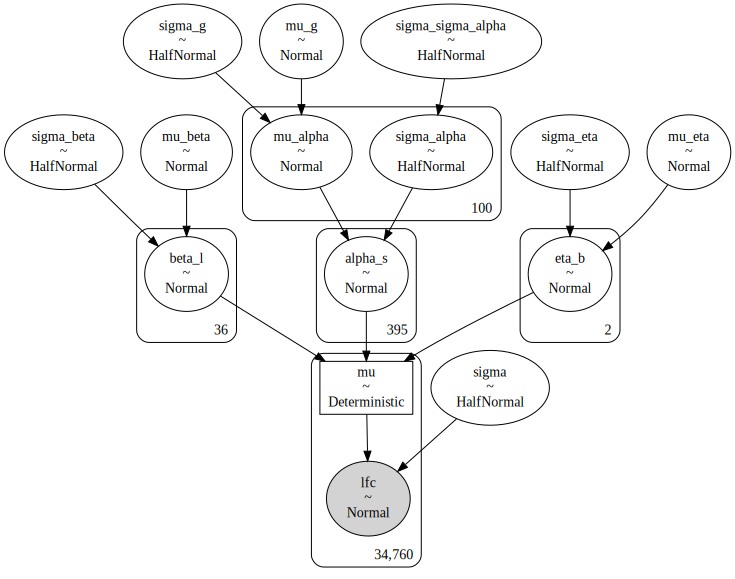

In [6]:
pm.model_to_graphviz(model)

In [7]:
with model:
    prior_pred = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

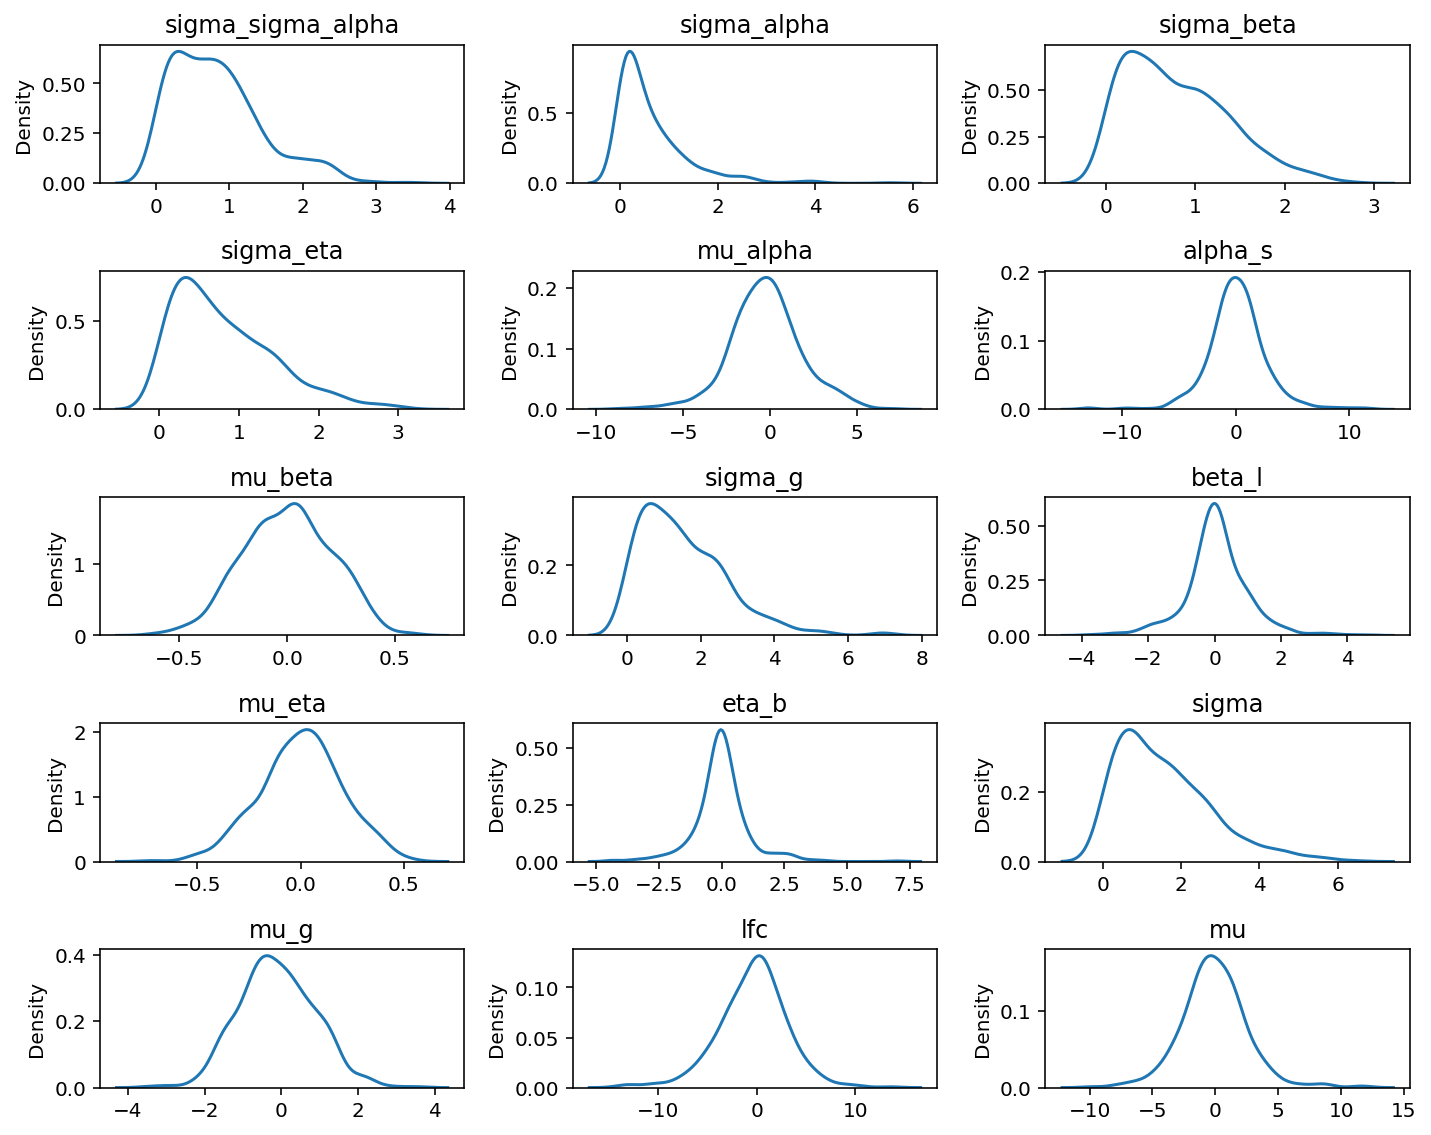

In [8]:
pmanal.plot_all_priors(prior_pred, subplots=(5, 3), figsize=(10, 8), samples=500);

In [9]:
batch_size = 1000

sgnra_idx_batch = pm.Minibatch(sgrna_idx, batch_size=batch_size)
cellline_idx_batch = pm.Minibatch(cellline_idx, batch_size=batch_size)
batch_idx_batch = pm.Minibatch(batch_idx, batch_size=batch_size)
lfc_data_batch = pm.Minibatch(data.lfc.values, batch_size=batch_size)

In [10]:
meanfield = pymc3_sampling_api.pymc3_advi_approximation_procedure(
    model=model,
    method="advi",
    callbacks=[
        pm.callbacks.CheckParametersConvergence(tolerance=0.01, diff="absolute")
    ],
    fit_kwargs={
        "more_replacements": {
            sgrna_idx_shared: sgnra_idx_batch,
            cellline_idx_shared: cellline_idx_batch,
            batch_idx_shared: batch_idx_batch,
            lfc_shared: lfc_data_batch,
        }
    },
)

Sampling from prior distributions.
Running ADVI approximation.


Convergence achieved at 27600
Interrupted at 27,599 [27%]: Average Loss = 967.8
Sampling from posterior.
Posterior predicitons.


In [11]:
az_model = pymc3_sampling_api.samples_to_arviz(model, meanfield)

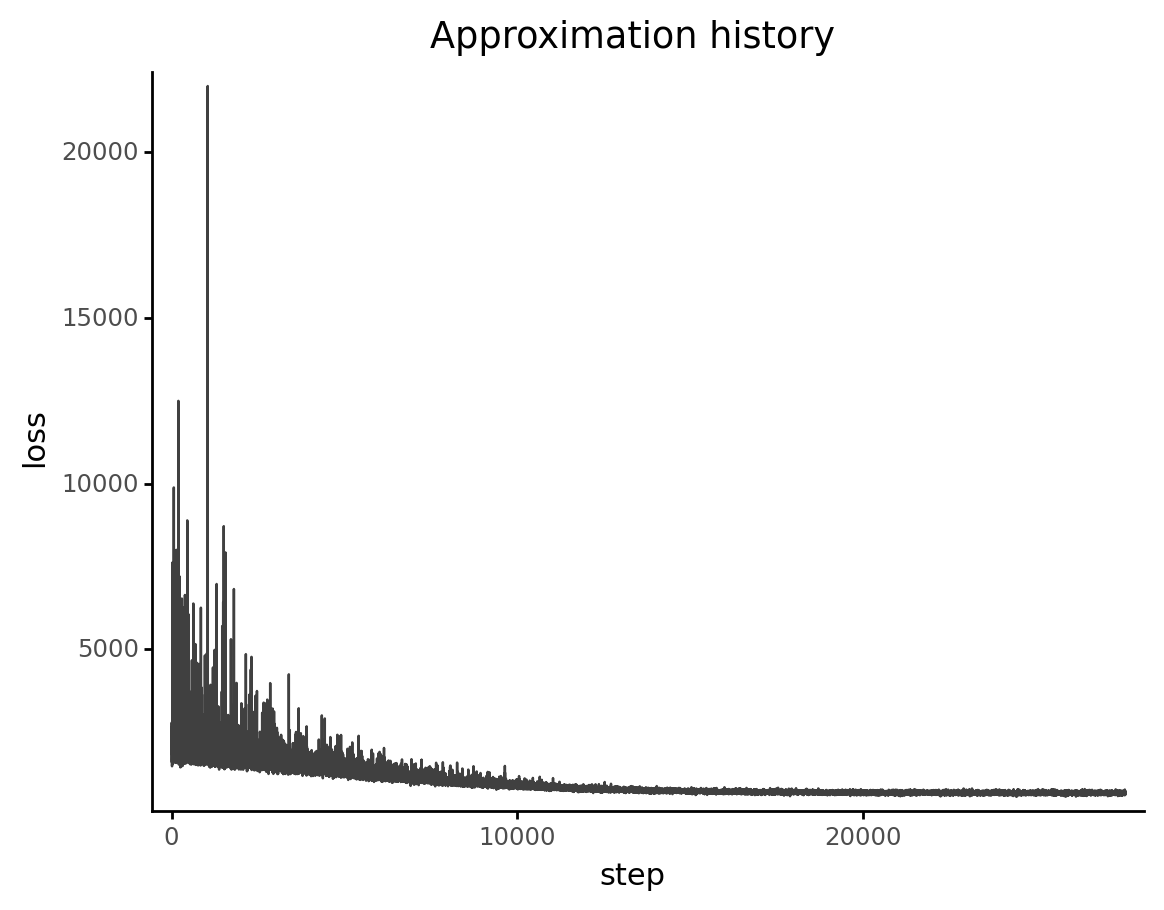

<ggplot: (351612685)>

In [12]:
pmanal.plot_vi_hist(meanfield["approximation"])

In [14]:
def plot_az_summary(df: pd.DataFrame, x="index") -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x=x))
        + gg.geom_hline(yintercept=0, linetype="--", alpha=0.5)
        + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2)
        + gg.geom_point(gg.aes(y="mean"), size=0.5)
        + gg.theme(axis_text_x=gg.element_text(angle=90, size=6))
        + gg.labs(x="model parameter", y="posterior")
    )

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


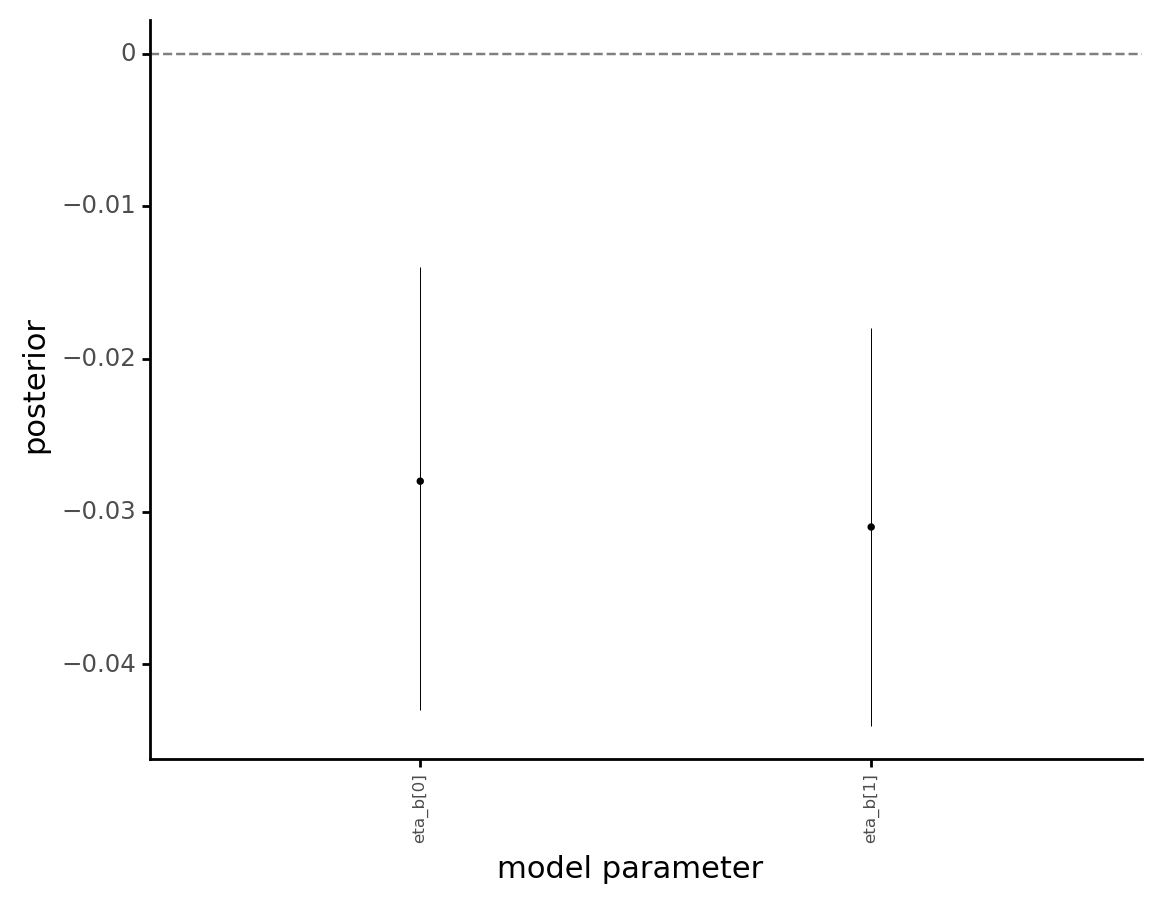

<ggplot: (348681807)>

In [15]:
batch_posteriors = az.summary(az_model, var_names="eta_b", hdi_prob=0.89)
plot_az_summary(batch_posteriors.reset_index(drop=False))

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


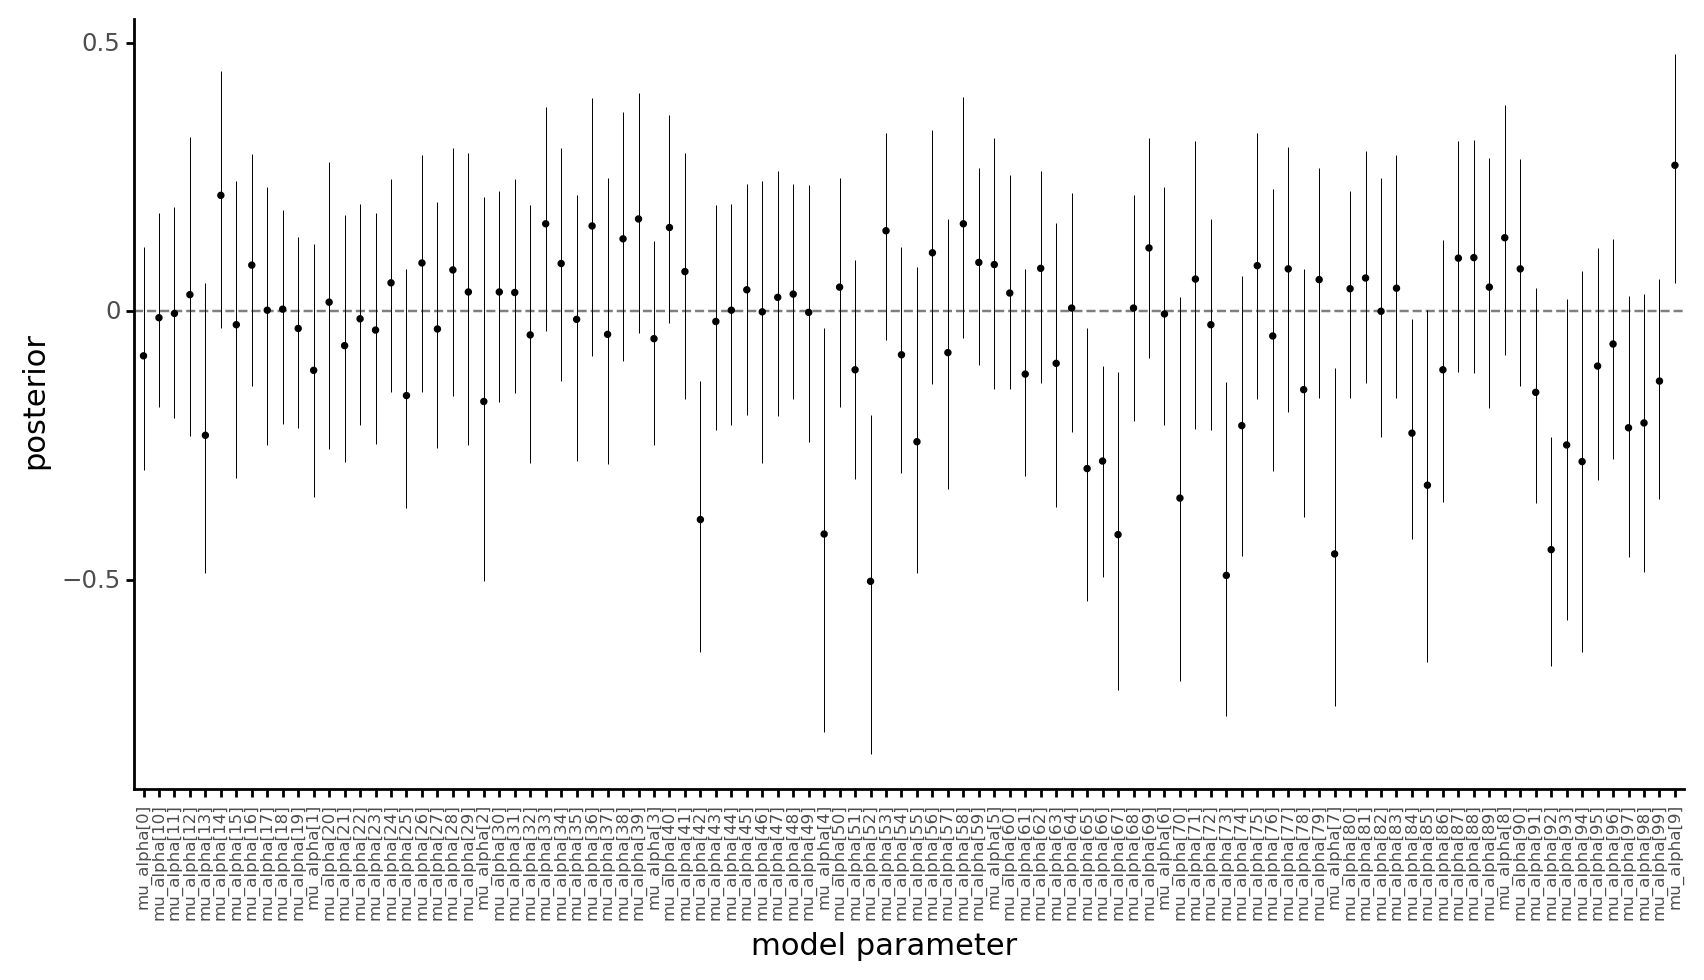

<ggplot: (349306646)>

In [16]:
gene_posteriors = az.summary(
    az_model,
    var_names="mu_alpha",
    hdi_prob=0.89,
)

plot_az_summary(gene_posteriors.reset_index(drop=False)) + gg.theme(figure_size=(10, 5))

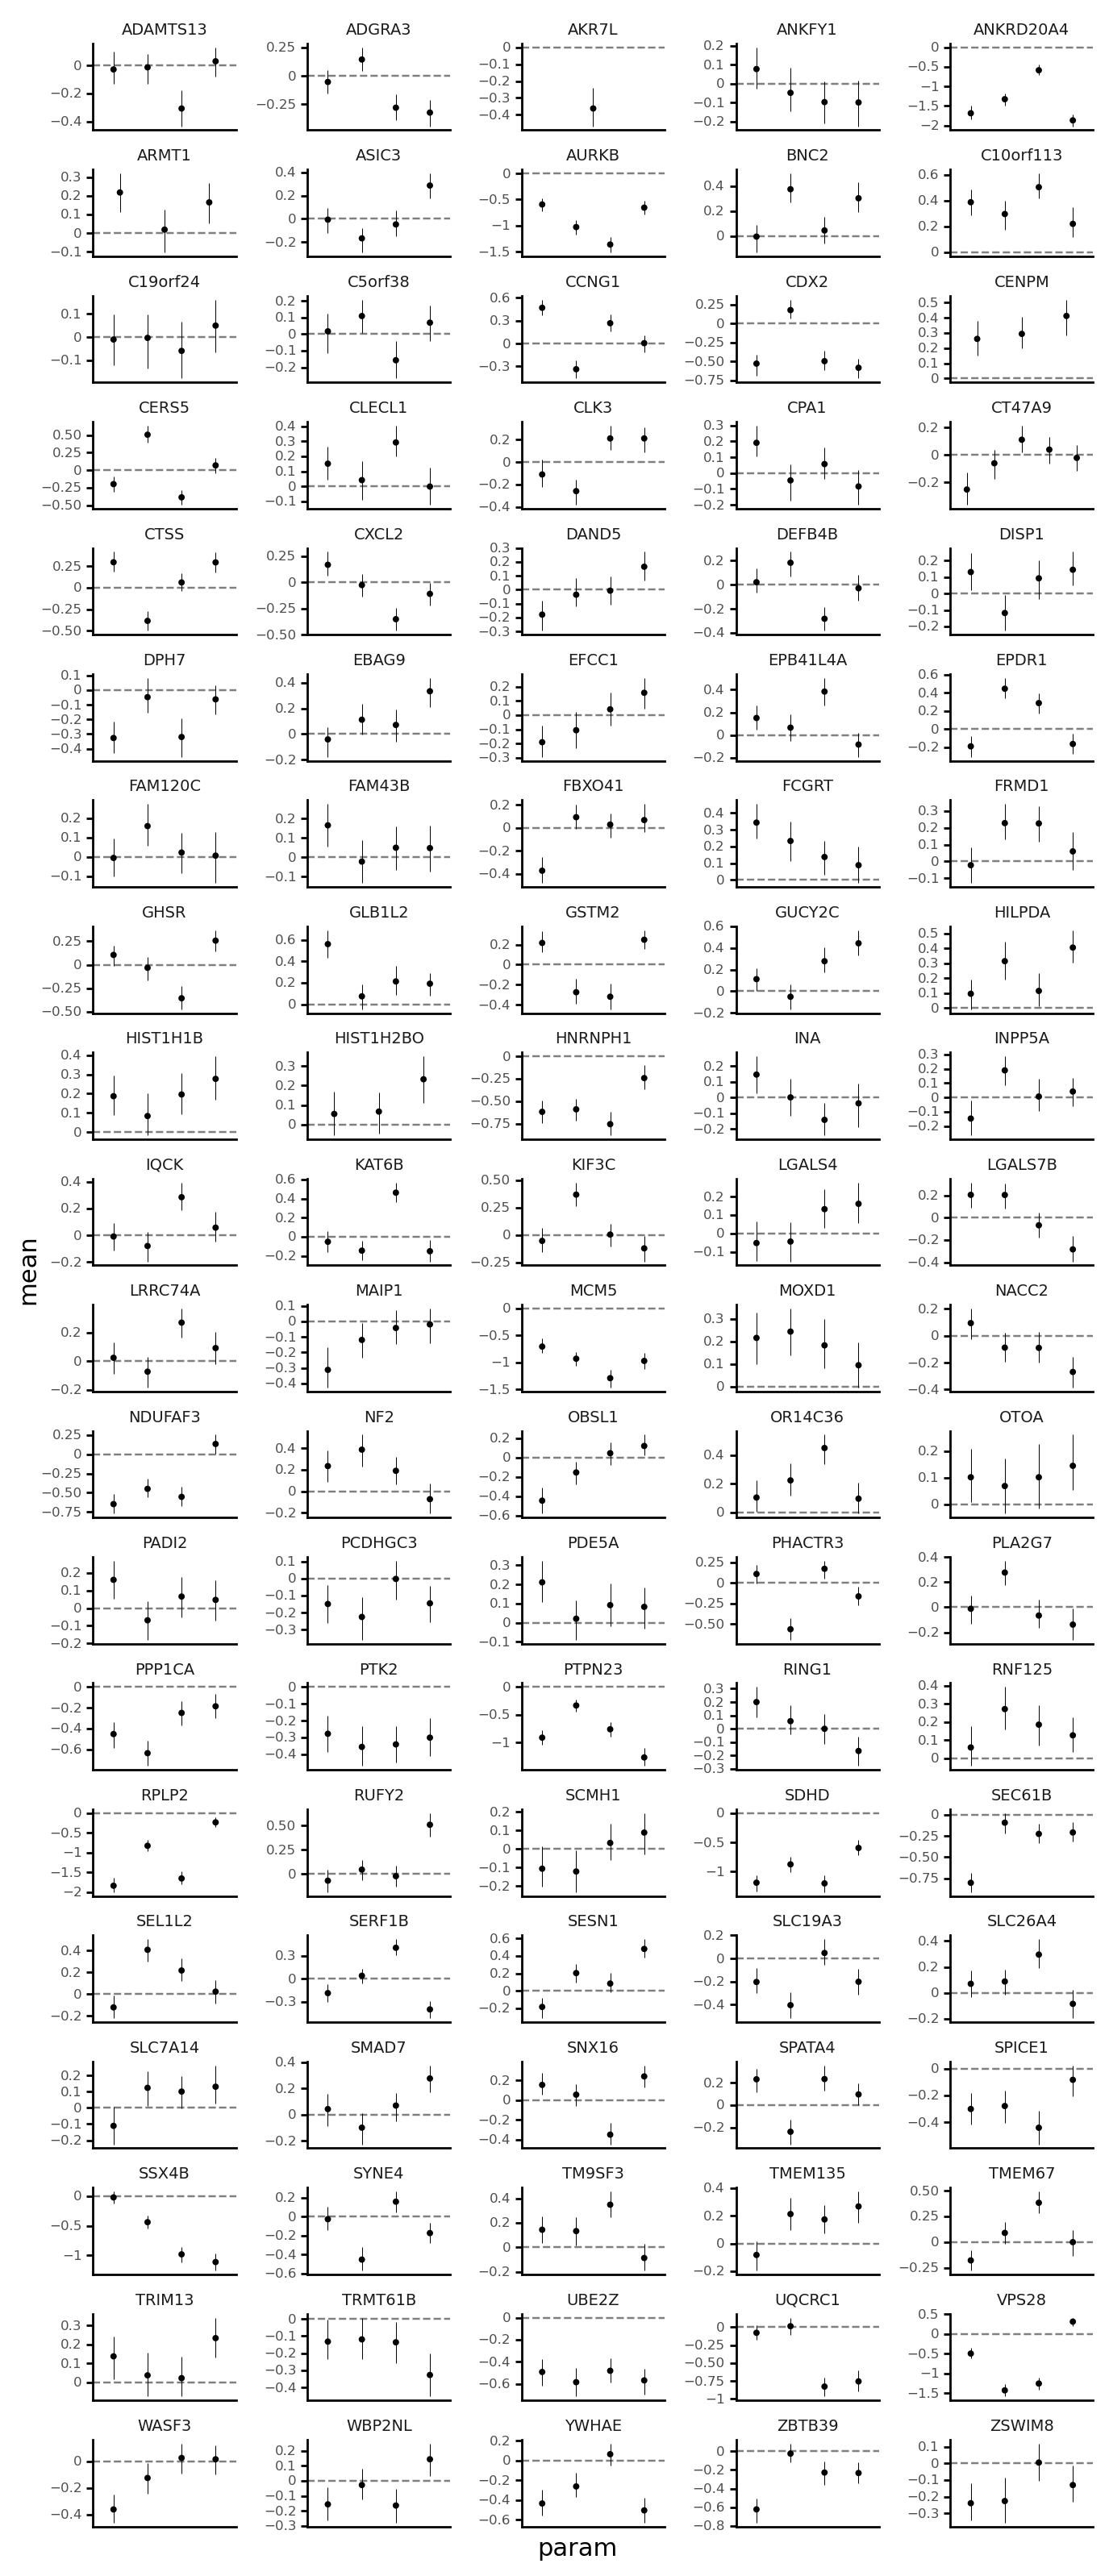

<ggplot: (351348363)>

In [17]:
sgrna_post = (
    az.summary(
        az_model,
        var_names="alpha_s",
        hdi_prob=0.89,
        kind="stats",
    )
    .reset_index(drop=False)
    .rename(columns={"index": "param"})
)
sgrna_post["sgrna"] = sgrna_to_gene_map.sgrna
sgrna_post["hugo_symbol"] = sgrna_to_gene_map.hugo_symbol

(
    gg.ggplot(sgrna_post, gg.aes(x="param"))
    + gg.facet_wrap("hugo_symbol", scales="free", ncol=5)
    + gg.geom_hline(yintercept=0, alpha=0.5, linetype="--")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=0.2)
    + gg.geom_point(gg.aes(y="mean"), size=0.6)
    + gg.theme(
        axis_text_x=gg.element_blank(),
        figure_size=(8, 20),
        subplots_adjust={"wspace": 0.5},
        axis_text_y=gg.element_text(size=6),
        axis_ticks_major_x=gg.element_blank(),
        strip_text=gg.element_text(size=7),
    )
)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


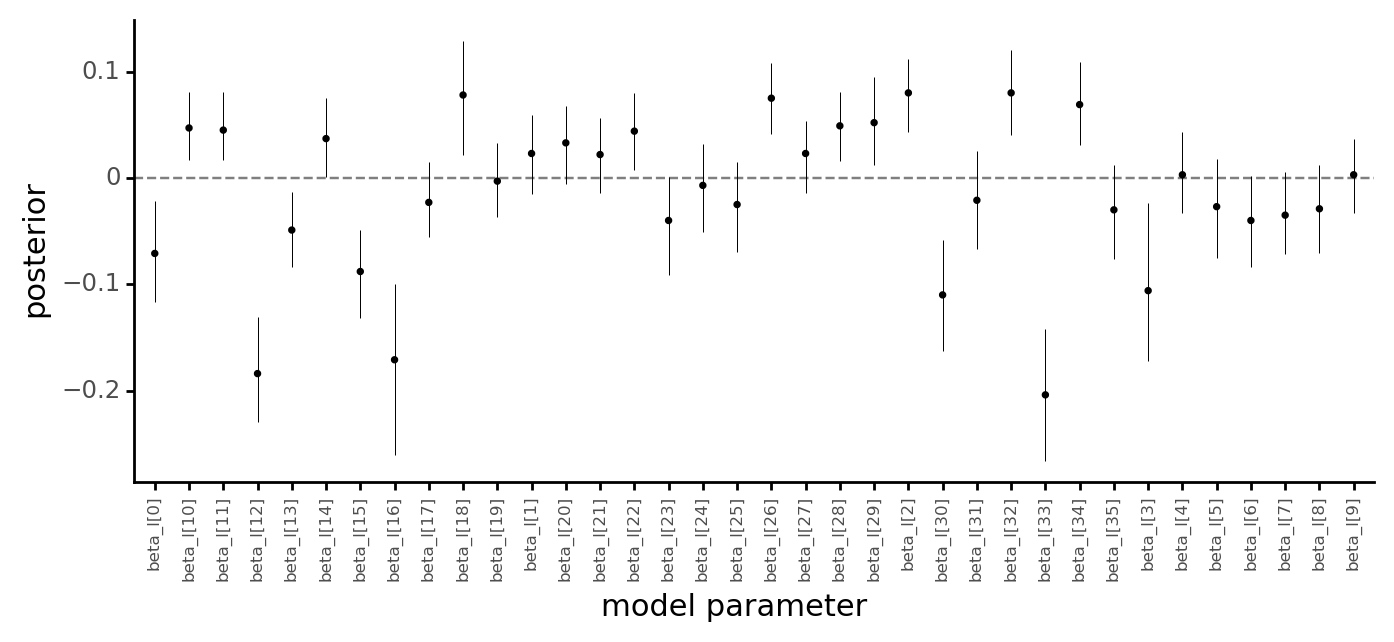

<ggplot: (352243444)>

In [18]:
cells_posteriors = az.summary(
    az_model,
    var_names="beta_l",
    hdi_prob=0.89,
)

plot_az_summary(cells_posteriors.reset_index(drop=False)) + gg.theme(figure_size=(8, 3))

---

In [19]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 5.31 minutes


In [20]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-02

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.20.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: crc-m1

pymc3     : 3.11.1
sys       : 3.9.1 | packaged by conda-forge | (default, Jan 26 2021, 01:32:59) 
[Clang 11.0.1 ]
numpy     : 1.20.1
re        : 2.2.1
matplotlib: 3.3.4
plotnine  : 0.7.1
arviz     : 0.11.1
seaborn   : 0.11.1
theano    : 1.0.5
pandas    : 1.2.2

